In [1]:
import sys
import os
sys.path.append(os.path.abspath('../'))

from evaluation import *
from data_loader import *
import random
from datetime import datetime

In [2]:
colors = {
    "DQN": 'darkorange',
    "PPO": 'forestgreen',
    "CMA": 'cyan',
    "ODT": 'blueviolet'
}

In [3]:
experiments = range(1030, 1038)

exp_agent_data = []

agg_counts = []

# REMOVE THIS
algos = ['DQN', 'PPO']
seasons = ['winter', 'summer']
agg_levels = [30, 6, 1]

for ind, exp_num in enumerate(experiments):
    config_fname = f'./Exp_{exp_num}/config.yaml'
    
    c = load_config_file(config_fname)
    nn_c = c['nn_hyperparameters']
    federated_c = c['federated_learning_settings']
    algo_c = c['algorithm_settings']
    env_c = c['environment_settings']
    eval_c = c['eval_config']

    ev_info = []

    seed = env_c['seed']

    algorithm_dm = algo_c['algorithm']
    
    def load_from_json_with_error_handling(filepath, columns_specific):
        try:
            return read_csv_data(filepath, columns=columns_specific)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON from {filepath}: {e.msg} at line {e.lineno}, column {e.colno}")
            return None  # Handle the error and return None or an empty object
    
    
    d_base = f"../../../../storage_1/metrics/Exp_{exp_num}"
    
    if not os.path.exists(d_base):
        d_base = f"../metrics/Exp_{exp_num}"
            
    base_path = f"{d_base}/train/metrics"

    print(f'Loading {base_path}_agent_metrics.csv')
    agent_data = load_from_json_with_error_handling(f'{base_path}_agent_metrics.csv', ['episode', 'timestep', 'done', 'zone', 'aggregation', 'agent_index', 'reward',])
    
    agent_data['seed'] = seed
    agent_data['exp_num'] = exp_num
    
    #agent_data['algorithm'] = algorithm_dm
    agent_data['algorithm'] = algos[ind % len(algos)] # REMOVE THIS AND UNCOMMENT PREVIOUS LINE!
    
    #agent_data['season'] = env_c['season']
    agent_data['season'] = seasons[(ind // len(algos) % len(seasons))] # REMOVE THIS AND UNCOMMENT PREVIOUS LINE!
    
    # agent_data['num_aggs'] = federated_c['aggregation_count']
    agent_data['num_aggs'] = agg_levels[ind % len(agg_levels)] # REMOVE THIS AND UNCOMMENT PREVIOUS LINE!
    
    agent_data['eps_per_agg'] = nn_c['num_episodes']

    exp_agent_data.append(agent_data)

Loading ../../../../storage_1/metrics/Exp_1030/train/metrics_agent_metrics.csv
Loading ../../../../storage_1/metrics/Exp_1031/train/metrics_agent_metrics.csv
Loading ../../../../storage_1/metrics/Exp_1032/train/metrics_agent_metrics.csv
Loading ../../../../storage_1/metrics/Exp_1033/train/metrics_agent_metrics.csv
Loading ../../../../storage_1/metrics/Exp_1034/train/metrics_agent_metrics.csv
Loading ../../../../storage_1/metrics/Exp_1035/train/metrics_agent_metrics.csv
Loading ../../../../storage_1/metrics/Exp_1036/train/metrics_agent_metrics.csv
Loading ../../../../storage_1/metrics/Exp_1037/train/metrics_agent_metrics.csv


In [4]:
# Convert data to DataFrame for easier manipulation
df_agent = pd.concat(exp_agent_data, ignore_index=True)

cumulative_agent_df = (
    df_agent
    .groupby(
        ['episode', 'zone', 'aggregation', 'agent_index', 'seed', 'exp_num', 'algorithm', 'season', 'num_aggs', 'eps_per_agg']
    )['reward']
    .sum()
    .reset_index()
)

# Rename the 'reward' column to 'cumulative_reward' for clarity
cumulative_agent_df.rename(columns={'reward': 'cumulative_reward'}, inplace=True)

# Get recalculated episodes using (aggregation number * episodes per aggregation) + episode number
cumulative_agent_df['episode'] = cumulative_agent_df['aggregation'] * cumulative_agent_df['eps_per_agg'] + cumulative_agent_df['episode']

cumulative_agent_df.head()

,episode,zone,aggregation,agent_index,seed,exp_num,algorithm,season,num_aggs,eps_per_agg,cumulative_reward
0,0,1,0,0,1234,1030,DQN,winter,30,200,-119.092580
1,0,1,0,0,1234,1033,PPO,summer,30,200,-104.519553
2,0,1,0,0,1234,1034,DQN,winter,6,200,-104.519553
3,0,1,0,0,1234,1035,PPO,winter,1,200,-104.519553
4,0,1,0,0,1234,1036,DQN,summer,30,200,-104.519553


In [5]:
cumulative_avg_reward_by_algorithm = (
    cumulative_agent_df
    .groupby(['episode', 'algorithm', 'seed', 'num_aggs', 'season'])['cumulative_reward']
    .mean()
    .reset_index()
)

cumulative_avg_reward_by_algorithm = cumulative_avg_reward_by_algorithm.sort_values(
    ['season', 'algorithm', 'seed', 'num_aggs', 'episode']
)

cumulative_avg_reward_by_algorithm['cumulative_reward'] = (
    cumulative_avg_reward_by_algorithm
    .groupby(['algorithm', 'seed', 'num_aggs', 'season'])['cumulative_reward']
    .transform(lambda x: x.expanding().mean())
)

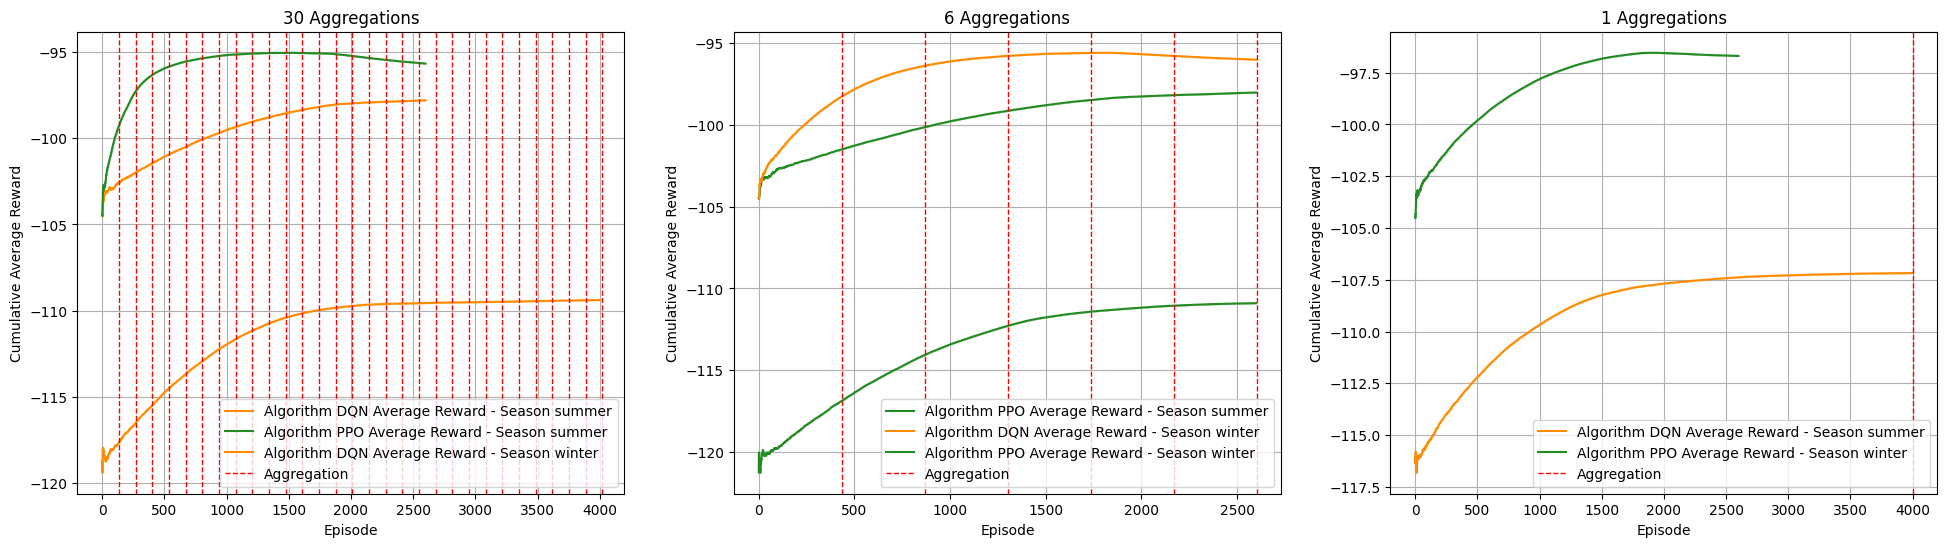

<Figure size 800x600 with 0 Axes>

In [17]:
agg_levels_sorted = sorted(cumulative_avg_reward_by_algorithm['num_aggs'].unique(), reverse=True)

num_plots = len(cumulative_avg_reward_by_algorithm['num_aggs'].unique())

fig, axes = plt.subplots(1, num_plots, figsize=(24, 6))  # Adjust figsize as needed

for plot_ind, agg_level in enumerate(agg_levels_sorted):
    ax = axes[plot_ind]
    
    agg_level_data = cumulative_avg_reward_by_algorithm.loc[cumulative_avg_reward_by_algorithm['num_aggs'] == agg_level]

    total_eps = agg_level_data['episode'].max()
    eps_per_agg = np.ceil(total_eps / agg_level)

    for season in agg_level_data['season'].unique():
        season_data = agg_level_data[agg_level_data['season'] == season]
        
        for algo in season_data['algorithm'].unique():
            # Filter the data for the current zone
            algo_data = season_data[season_data['algorithm'] == algo]
            
            min_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].min()
            max_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].max()
            mean_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].mean()
        
            ax.fill_between(
                min_cumulative_avg_reward.index, 
                min_cumulative_avg_reward.values, 
                max_cumulative_avg_reward.values,
                color=colors[algo],
                alpha=0.3
            )
            ax.plot(
                mean_cumulative_avg_reward.index, 
                mean_cumulative_avg_reward.values,
                color=colors[algo],
                label=f'Algorithm {algo} Average Reward - Season {season}'
            )

    for agg in range(1, agg_level + 1):
        if agg == 1:
            ax.axvline(x=(agg * eps_per_agg), color='r', linestyle='--', linewidth=1, label='Aggregation')
        else:
            ax.axvline(x=(agg * eps_per_agg), color='r', linestyle='--', linewidth=1)
    
    ax.set_xlabel('Episode')
    ax.set_ylabel('Cumulative Average Reward')
    ax.set_title(f'{agg_level} Aggregations')
    ax.legend(loc='lower right')
    ax.grid(True)

fig.show()

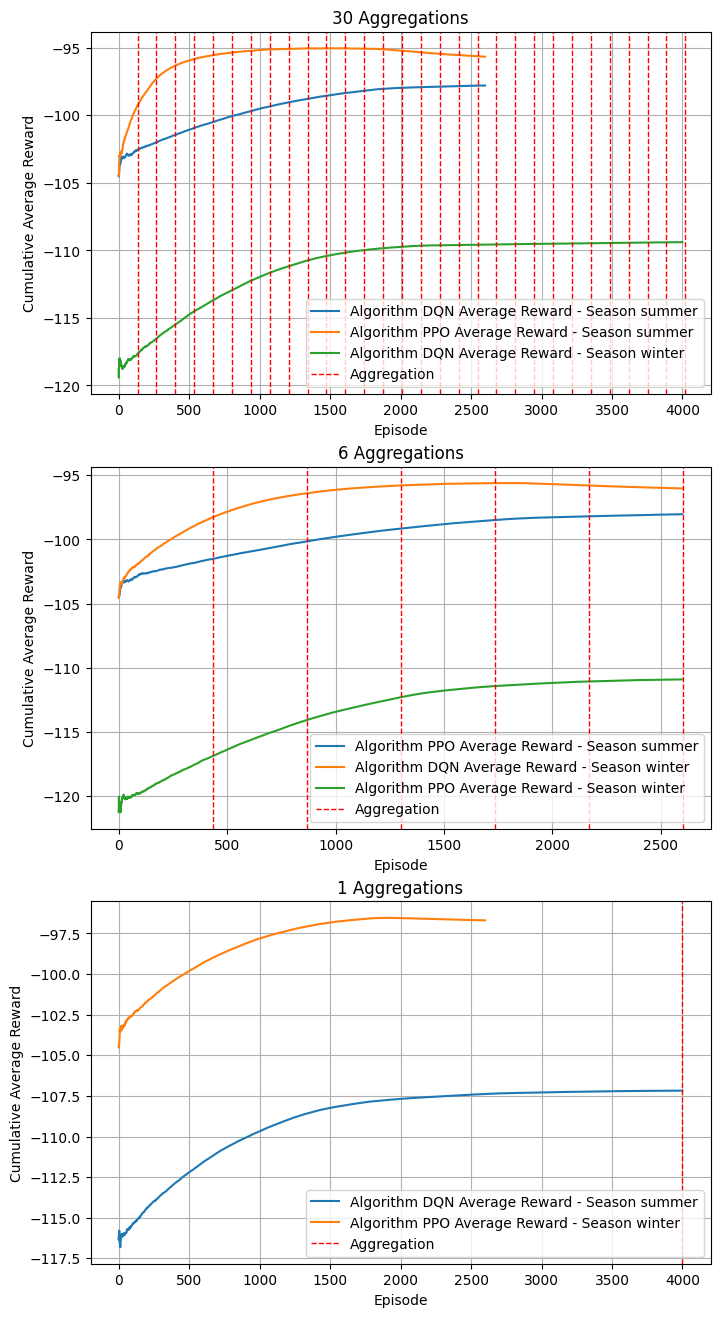

<Figure size 800x600 with 0 Axes>

In [18]:
agg_levels_sorted = sorted(cumulative_avg_reward_by_algorithm['num_aggs'].unique(), reverse=True)

num_plots = len(cumulative_avg_reward_by_algorithm['num_aggs'].unique())

fig, axes = plt.subplots(num_plots, 1, figsize=(8, 16))  # Adjust figsize as needed

for plot_ind, agg_level in enumerate(agg_levels_sorted):
    ax = axes[plot_ind]
    
    agg_level_data = cumulative_avg_reward_by_algorithm.loc[cumulative_avg_reward_by_algorithm['num_aggs'] == agg_level]

    total_eps = agg_level_data['episode'].max()
    eps_per_agg = np.ceil(total_eps / agg_level)

    for season in agg_level_data['season'].unique():
        season_data = agg_level_data[agg_level_data['season'] == season]
        
        for algo in season_data['algorithm'].unique():
            # Filter the data for the current zone
            algo_data = season_data[season_data['algorithm'] == algo]
            
            min_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].min()
            max_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].max()
            mean_cumulative_avg_reward = algo_data.groupby('episode')['cumulative_reward'].mean()
        
            ax.fill_between(
                min_cumulative_avg_reward.index, 
                min_cumulative_avg_reward.values, 
                max_cumulative_avg_reward.values, 
                alpha=0.3
            )
            ax.plot(
                mean_cumulative_avg_reward.index, 
                mean_cumulative_avg_reward.values, 
                label=f'Algorithm {algo} Average Reward - Season {season}'
            )

    for agg in range(1, agg_level + 1):
        if agg == 1:
            ax.axvline(x=(agg * eps_per_agg), color='r', linestyle='--', linewidth=1, label='Aggregation')
        else:
            ax.axvline(x=(agg * eps_per_agg), color='r', linestyle='--', linewidth=1)
        
    ax.set_xlabel('Episode')
    ax.set_ylabel('Cumulative Average Reward')
    ax.set_title(f'{agg_level} Aggregations')
    ax.legend(loc='lower right')
    ax.grid(True)

fig.show()